# Prediksi penjualan Perusahaan Rusty Bargain

Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kamu bisa dengan cepat mengetahui nilai pasar mobilmu. Kamu memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugasmu adalah membuat suatu model yang mampu menentukan nilai pasar mobil.
Rusty Bargain tertarik pada:

- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

## Persiapan Data

### Memasukkan modul library yang dibutuhkan

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, make_scorer
from sklearn.compose import TransformedTargetRegressor

# Additional libraries
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv

# Visualization
sns.set_theme(palette='bright')


Matplotlib is building the font cache; this may take a moment.


### Menyimpan dan memeriksa data

In [2]:
# Mengunduh dan memeriksa data
car_data = pd.read_csv('/datasets/car_data.csv')

# menampilkan data
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
#memeriksa informasi
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

terlihat bahwa dataset berisikan `16` kolom dengan `354368` entry data, kolom memiliki judul kolom yang besar kecil sehingga harus ditangani terlebih dahulu, terdapat beberapa tipe data yang salah pada kolom `DateCrawled`, `DateCreated` dan `LastSeen` yang seharusnya dengan tipe data `datetime`. terlihat ada beberapa kolom yang memiliki nilai yang hilang.

### Mengubah judul kolom dan tipe data

In [4]:
#mengubah kolom menjadi kecil semua
car_data.columns = car_data.columns.str.lower()

In [5]:
# mengubah tipe data tanggal menjadi datetime
car_data['datecrawled'] = pd.to_datetime(car_data['datecrawled'], format='%d/%m/%Y %H:%M')
car_data['datecreated'] = pd.to_datetime(car_data['datecreated'], format='%d/%m/%Y %H:%M')
car_data['lastseen'] = pd.to_datetime(car_data['lastseen'], format='%d/%m/%Y %H:%M')

In [6]:
#memeriksa informasi
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   mileage            354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  notrepaired        283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

sekarang tipe data yang mengandung tanggal sudah diubah menjadi datetime, dan kolom sudah menjadi kecil semua.

### Memeriksa setiap kolom numerik

In [7]:
# melihat statistik deskriptif data numerik
car_data.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


terlihat beberapa informasi yang janggal dan tidak masuk akal seperti berikut:
1. Kolom `price` terdapat nilai yang bernilai `nol`.
2. Kolom `registrationyear` memiliki tahun terendah `1000` dan tertinggi `9999`. yang mana ini tidak seharusnya terjadi
3. Kolom `power` memiliki daya terendah `0` dan tertinggi `20000`.
4. Kolom `registrationmonth` memiliki bulan registrasi terendah `0`.
5. Kolom `numberofpictures` semua data bernilai `nol`.

In [8]:
# melihat distribusi tahun registrasi
regisyear = car_data['registrationyear'].unique()
np.sort(regisyear)

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

terlihat bahwa banyak sekali nilai yang tidak masuk akal, seperti tahun dengan angka `1000` hingga `9999` karena ini bukan nilai hilang, diputuskan untuk menghapusnya

In [9]:
# melihat distribusi power
power = car_data['power'].unique()
np.sort(power)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

seperti sebelumnya nilai ini sangat tidak masuk akal sehingga harus dihilangkan

In [10]:
# menghilangkan harga (price) yang nol
car_data = car_data[car_data['price'] >= 500]

# memfilter tahun registrasi dari 1900 hingga 2020
car_data = car_data[(car_data['registrationyear'] >= 1900)&(car_data['registrationyear'] <= 2020)]

# memfilter power dari > 0 dan kurang dari sama dengan 2000
car_data = car_data[(car_data['power'] != 0)&(car_data['power'] <= 2000)]

# memfilter registrasi bulan membuang bulan 0
car_data = car_data[car_data['registrationmonth'] != 0]


In [11]:
# menampilkan kembali statistik deskriptif untuk data numerik
car_data.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,273337.000000,273337.000000,273337.000000,273337.000000,273337.000000,273337.0,273337.000000
mean,5211.992416,2003.617194,123.716423,127428.064989,6.396452,0.0,51478.623615
std,4622.035318,6.722419,62.335180,37005.460544,3.346175,0.0,25700.754631
min,500.000000,1910.000000,1.000000,5000.000000,1.000000,0.0,1067.000000
25%,1600.000000,2000.000000,82.000000,125000.000000,4.000000,0.0,31162.000000
50%,3550.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50739.000000
75%,7500.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72213.000000
max,20000.000000,2019.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


sekarang data sudah dikurangi nilai-nilai tidak masuk akalnya

### Memeriksa kolom Kategorik

In [12]:
# melihat statistik deskriptif untuk data categorik
car_data.select_dtypes(exclude=['int','float','datetime']).describe()

,vehicletype,gearbox,model,fueltype,brand,notrepaired
count,259339,269557,264340,260580,273337,240529
unique,8,2,249,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,76697,212692,22714,169396,58842,218617


terlihat bahwa data `vehicletype` memiliki 8 unik data, dengan top `sedan`, `gearbox` memiliki 2 unik data, dan top `manual`, `fueltype` memiliki 7 unik dara dn yang paling banyak petrol, `brand` terlihat memiliki sebanyak 40 unik data, dengan top `volkswagen` dan `notrepaired` memiliki 2 unik data dengan top `no`.

In [13]:
car_data['vehicletype'].value_counts()

sedan          76697
small          59728
wagon          54293
bus            25083
convertible    17768
coupe          13161
suv            10572
other           2037
Name: vehicletype, dtype: int64

In [14]:
# menampilkan informasi lain
print('First DateCreated', min(car_data['datecreated']))
print('Last DateCreated', max(car_data['datecreated']))
print('First DateCrawled', min(car_data['datecrawled']))
print('Last DateCrawled', max(car_data['datecrawled']))

First DateCreated 2015-08-07 00:00:00
Last DateCreated 2016-04-07 00:00:00
First DateCrawled 2016-03-05 14:06:00
Last DateCrawled 2016-04-07 14:36:00


### Mengurangi `drop` kolom yang tidak dibutuhkan dan `drop` duplikasi data

In [15]:
# melakukan drop untuk semua data yang tidak dibutuhkan
data = car_data.drop(['datecrawled','datecreated','lastseen', 'numberofpictures', 'postalcode'],axis=1)

# jumlah dataset awal
print('Jumlah dataset awal', len(car_data))

# jumlah duplikasi data
print('Jumlah duplikasi data',data.duplicated().sum())

# menghilangkan duplikasi data
data.drop_duplicates(inplace=True)

# jumlah datset akhir
print('Jumlah dataset akhir', len(data))

Jumlah dataset awal 273337
Jumlah duplikasi data 22244
Jumlah dataset akhir 251093


dataset memiliki banyak sekali duplikasi data, karena itu diputuskan untuk menghapusnya saja. sekarang jumlah dataset adalah `251093` entry

### Memeriksa nilai hilang

In [16]:
# mengecek nilai yang hilang pada dataset
data.isna().sum()

price                    0
vehicletype          13421
registrationyear         0
gearbox               3636
power                    0
model                 8645
mileage                  0
registrationmonth        0
fueltype             12381
brand                    0
notrepaired          31007
dtype: int64

In [17]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [18]:
#fungsi persentase missing values
missing_percentage = data.isna().sum() / len(data) * 100
missing_percentage

price                 0.000000
vehicletype           5.345032
registrationyear      0.000000
gearbox               1.448069
power                 0.000000
model                 3.442947
mileage               0.000000
registrationmonth     0.000000
fueltype              4.930842
brand                 0.000000
notrepaired          12.348811
dtype: float64

terlihat banyak cukup banyak nilai hilang pada data, terutama pada data kategorik, sehingga ini tidak bisa diisi dengan mudah.

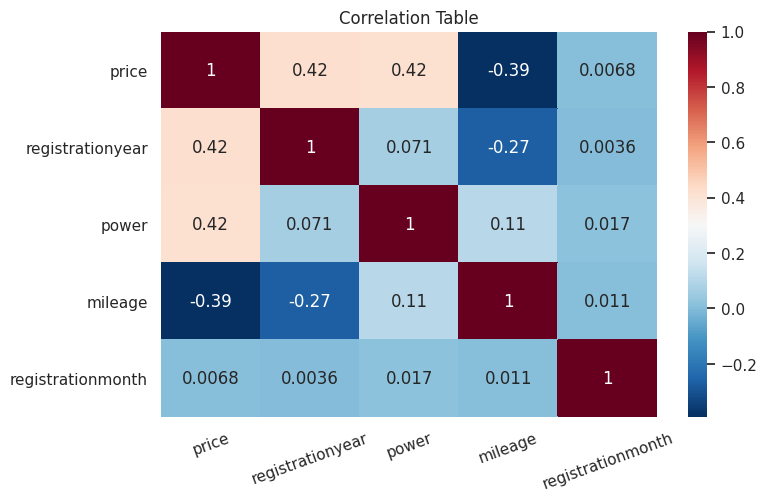

In [19]:
# mengecek korelasi pada dataset numerik
plt.figure(figsize=(8,5))
sns.heatmap(data.select_dtypes(exclude='object').corr(),annot=True,cmap='RdBu_r')
plt.title('Correlation Table')
plt.xticks(rotation=20)
plt.show()

tabel korelasi sudah menunjukkan korelasi antara kolom-kolom numerik satu sama lainnya,terlihat bahwa kolom `price` berkorelasi kuat dengan kolom `registrationyear` dan `power`

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251093 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              251093 non-null  int64 
 1   vehicletype        237672 non-null  object
 2   registrationyear   251093 non-null  int64 
 3   gearbox            247457 non-null  object
 4   power              251093 non-null  int64 
 5   model              242448 non-null  object
 6   mileage            251093 non-null  int64 
 7   registrationmonth  251093 non-null  int64 
 8   fueltype           238712 non-null  object
 9   brand              251093 non-null  object
 10  notrepaired        220086 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.0+ MB


**Kesimpulan:**
1. terlihat bahwa dataset berisikan `16` kolom dengan `354368` entry data
2. kolom memiliki judul kolom yang besar kecil sehingga harus diperbaiki
3. terdapat beberapa tipe data yang salah pada kolom `DateCrawled`, `DateCreated` dan `LastSeen` yang seharusnya dengan tipe data `datetime`
4. terlihat ada beberapa kolom yang memiliki nilai yang hilang.
5. kolom-kolom numerik berisikan nilai yang tidak masuk akal sehingga diputuskan menghapusnya
6. terdapat banyak sekali duplikasi data sehingga diputuskan menghapusnya
7. terdpaat kolom-kolom yang dibutuhkan diputuskan untuk menghapusnya

dataset sekarang berisikan `11` kolom dengan `251093` masih terdapat nilai hilang pada kolom kategorik

## Pelatihan Model

sebelum memasuki langkah untuk melatih model, diputuskan terlebih dahulu untuk menangangi nilai hilang yang sebelumnya sudah dibahas, untuk mempermudah pelatihan model selanjutnya

In [21]:
# Memisahkan fitur dan target
features = data.drop(['price', 'model'], axis=1)
target = data['price']

# Daftar kolom numerik dan kategorik
num_col = features.select_dtypes(include=['int', 'float']).columns
cat_onehot_col = ['vehicletype', 'gearbox', 'fueltype', 'notrepaired']
cat_ordinal_col = ['brand']

# Transformer untuk data numerik
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Transformer untuk data kategorik (OneHot)
categorical_onehot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transformer untuk data kategorik (Ordinal)
categorical_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Menggabungkan transformer numerik dan kategorik
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical, num_col),
    ('cat_onehot', categorical_onehot, cat_onehot_col),
    ('cat_ordinal', categorical_ordinal, cat_ordinal_col)
])

# Memisahkan data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Preprocess data
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

In [22]:
x_train.head()

,vehicletype,registrationyear,gearbox,power,mileage,registrationmonth,fueltype,brand,notrepaired
124667,suv,2006,auto,232,150000,6,gasoline,audi,yes
329565,wagon,2003,manual,131,150000,6,petrol,audi,no
143141,small,1999,manual,60,90000,9,petrol,citroen,no
240177,convertible,1984,manual,126,125000,5,petrol,alfa_romeo,no
99408,convertible,1999,auto,218,150000,1,petrol,mercedes_benz,no


membuat fungsi untuk digunakan sebagai pelatihan model:

In [23]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    # Train the model
    time_start = time.time()
    model.fit(x_train, y_train)
    time_end = time.time()
    training_time = np.round(time_end - time_start, 3)
    
    # Make predictions
    predictions = model.predict(x_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return training_time, rmse

fungsi ini digunakan untuk melihat waktu yang dibutuhkan dan nilai `RSME` tiap model

### Linear regression

In [24]:
#Model linear regression
linreg = LinearRegression()

# Memanggil fungsi dan menangkap hasilnya
linreg_time, linreg_rmse = train_and_evaluate_model(linreg, x_train_processed, y_train, x_test_processed, y_test, model_name='Linear Regression')

# Menampilkan hasil
print(f'Linear Regression - Waktu Pelatihan: {linreg_time} detik')
print(f'Linear Regression - RMSE: {linreg_rmse}')

Linear Regression - Waktu Pelatihan: 0.88 detik
Linear Regression - RMSE: 3107.3839271924276


terlihat bahwa waktu yang dibutuhkan untuk model ini cukup singkat yaitu 0.327 detik dengan RMSE 3107, nilai RSME ini tidak terlalu baik, tapi mari kita bandingkan dengan model lainnya

### Random Forest

In [25]:
#model random forest
rf = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=10, random_state=42)

rf_time, rf_rmse = train_and_evaluate_model(rf, x_train_processed, y_train, x_test_processed, y_test, model_name='Random Forest')

print(f'Random Forest - Waktu Pelatihan: {rf_time} detik')
print(f'Random Forest - RMSE: {rf_rmse}')

Random Forest - Waktu Pelatihan: 39.707 detik
Random Forest - RMSE: 1943.3301949007591


terlihat bahwa waktu yang dibutuhkan untuk model ini lebih lama yaitu 12.338 detik dengan RMSE 1943, nilai RSME ini lebih rendah daripada model sebelumnya

### Decision tree

In [26]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)

dtr_time, dtr_rmse = train_and_evaluate_model(dtr, x_train_processed, y_train, x_test_processed, y_test, model_name='Decision Tree')

print(f'Decision Tree - Waktu Pelatihan: {dtr_time} detik')
print(f'Decision Tree - RMSE: {dtr_rmse}')

Decision Tree - Waktu Pelatihan: 3.424 detik
Decision Tree - RMSE: 2027.2362697356696


terlihat bahwa waktu yang dibutuhkan untuk model ini cukup singkat yaitu 1.016 detik dengan RMSE 2027, nilai RSME ini berada ditengah dari 2 model sebelumnya

### Gradient Boosting

In [27]:
gbr = GradientBoostingRegressor(n_estimators=20, max_depth=10, min_samples_split=10, random_state=42)

gbr_time, gbr_rmse = train_and_evaluate_model(gbr, x_train_processed, y_train, x_test_processed, y_test, model_name='Gradient Boosting')

print(f'Gradient Boosting - Waktu Pelatihan: {gbr_time} detik')
print(f'Gradient Boosting - RMSE: {gbr_rmse}')

Gradient Boosting - Waktu Pelatihan: 67.081 detik
Gradient Boosting - RMSE: 1864.479495363515


terlihat bahwa waktu yang dibutuhkan untuk model ini lebih lama lagi dibandingkan model-model sebelumnya yaitu 20.213 detik dengan RMSE 1864, nilai RSME ini tidak terlalu buruk dibandingkan model sebelumnya

### Light LGBM

In [28]:
lgbr = lgb.LGBMRegressor(n_estimators=20, max_depth=10, learning_rate=0.1, random_state=42)

lgbr_time, lgbr_rmse = train_and_evaluate_model(lgbr, x_train_processed, y_train, x_test_processed, y_test, model_name='LGBMRegressor')

print(f'LGBMRegressor - Waktu Pelatihan: {lgbr_time} detik')
print(f'LGBMRegressor - RMSE: {lgbr_rmse}')

LGBMRegressor - Waktu Pelatihan: 77.819 detik
LGBMRegressor - RMSE: 2139.0420231392422


terlihat bahwa waktu yang dibutuhkan untuk model ini cukup cepat yaitu 1.069 detik dengan RMSE 2139, nilai RSME ini tidak terlalu buruk dibandingkan model sebelumnya

### XGBoost Regressor

In [29]:
xgbr = XGBRegressor(n_estimators=20, max_depth=10, learning_rate=0.1, random_state=42)

xgbr_time, xgbr_rmse = train_and_evaluate_model(xgbr, x_train_processed, y_train, x_test_processed, y_test, model_name='XGBRegressor')

print(f'XGBRegressor - Waktu Pelatihan: {xgbr_time} detik')
print(f'XGBRegressor - RMSE: {xgbr_rmse}')

XGBRegressor - Waktu Pelatihan: 71.194 detik
XGBRegressor - RMSE: 1975.9565884762521


terlihat bahwa waktu yang dibutuhkan untuk model ini cukup lama yaitu 19.814  detik dengan RMSE 1975, nilai RSME ini cukup baik dibandingkan model sebelumnya

### CatBoost Regressor

In [30]:
cbr = CatBoostRegressor(n_estimators=20, max_depth=10, learning_rate=0.1, random_state=42, verbose=0)

cbr_time,cbr_rmse = train_and_evaluate_model(cbr, x_train_processed, y_train, x_test_processed, y_test, model_name='CatBoost Regressor')

print(f'CatBoost Regressor - Waktu Pelatihan: {cbr_time} detik')
print(f'CatBoost Regressor - RMSE: {cbr_rmse}')

CatBoost Regressor - Waktu Pelatihan: 14.392 detik
CatBoost Regressor - RMSE: 2110.029743189009


terlihat bahwa waktu yang dibutuhkan untuk model ini cukup baik yaitu  4.715  detik dengan RMSE 2110, nilai RSME ini cukup baik dibandingkan model sebelumnya

In [31]:
# Menggabungkan hasil model
results = [
    {'Model': 'Linear Regression', 'Training Time (s)': linreg_time, 'RMSE': linreg_rmse},
    {'Model': 'Random Forest', 'Training Time (s)': rf_time, 'RMSE': rf_rmse},
    {'Model': 'Decision Tree', 'Training Time (s)': dtr_time, 'RMSE': dtr_rmse},
    {'Model': 'Gradient Boosting', 'Training Time (s)': gbr_time, 'RMSE': gbr_rmse},
    {'Model': 'LightGBM', 'Training Time (s)': lgbr_time, 'RMSE': lgbr_rmse},
    {'Model': 'XGBoost', 'Training Time (s)': xgbr_time, 'RMSE': xgbr_rmse},
    {'Model': 'CatBoost', 'Training Time (s)': cbr_time, 'RMSE': cbr_rmse}
]

# Mengubah hasil menjadi DataFrame
results_df = pd.DataFrame(results)

# Menampilkan tabel hasil
results_df

,Model,Training Time (s),RMSE
0,Linear Regression,0.880,3107.383927
1,Random Forest,39.707,1943.330195
2,Decision Tree,3.424,2027.236270
3,Gradient Boosting,67.081,1864.479495
4,LightGBM,77.819,2139.042023
5,XGBoost,71.194,1975.956588
6,CatBoost,14.392,2110.029743


**Kesimpulan:**
1. terlihat bahwa model yang paling cepat dalam eksekusi adalah model `linear regression` dengan waktu `0.32` detik akan tetapi memiliki nilai `rsme` yang tertinggi yaitu `3107`
2. untuk nilai `rsme` terendah adalah dengan menggunakan `gradient boosting` dengan nilai `1864` akan tetapi model ini memiliki waktu eksekusi terlama yaitu selama `20` detik
3. untuk model `catboost`, `lightlgbm` dan `decision tree` menghasilkan waktu eksekusi yang tidak sampai `5` detik, dengan nilai `rsme` yang tidak jauh berbeda. 

pada tahap ini sepertinya model terbaik untuk digunakan adalah model `decision tree` dengan waktu eksekusi `1.016` dan nilai `rsme` `2027`.

## Analisis Model

### Linear Regression analisis

In [32]:
# Latih model 
linreg.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi 
time_start = time.time()
predict_train_lr = linreg.predict(x_train_processed)
predict_test_lr = linreg.predict(x_test_processed)
time_end = time.time()
diff_pred_linreg = np.round(time_end - time_start, 3)
total_linreg = np.round(linreg_time + diff_pred_linreg, 3)
print('Waktu untuk predicting:', f'{diff_pred_linreg}','detik')
print('Total waktu linreg:', f'{total_linreg}','detik')

cross_linreg = cross_val_score(linreg, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error')
cross_linreg = np.mean(np.sqrt(-cross_linreg)).round(2)

# Menghitung RMSE pada data test
pred_linreg = np.sqrt(mean_squared_error(y_test, predict_test_lr)).round(2)
print('RMSE test linreg:', pred_linreg)
print('RMSE cross linreg:', cross_linreg)

Waktu untuk predicting: 0.078 detik
Total waktu linreg: 0.958 detik
RMSE test linreg: 3107.38
RMSE cross linreg: 3130.67


terlihat bahwa waktu prediksi sangat singkat hanya `0.026` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `0.428` detik

### Random Forest analisis

In [33]:
# Latih model 
rf.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi 
time_start = time.time()
predict_train_rf = rf.predict(x_train_processed)
predict_test_rf = rf.predict(x_test_processed)
time_end = time.time()
diff_pred_rf = np.round(time_end - time_start, 3)
total_rf = np.round(rf_time + diff_pred_rf, 3)
print('Waktu untuk predicting:', f'{diff_pred_rf}','detik')
print('Total waktu random forest:', f'{total_rf}','detik')

cross_rf = cross_val_score(rf, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error')
cross_rf = np.mean(np.sqrt(-cross_rf)).round(2)

# Menghitung RMSE pada data test
pred_rf = np.sqrt(mean_squared_error(y_test, predict_test_rf)).round(2)
print('RMSE test random forest:', pred_rf)
print('RMSE cross random forest:', cross_rf)

Waktu untuk predicting: 1.892 detik
Total waktu random forest: 41.599 detik
RMSE test random forest: 1943.33
RMSE cross random forest: 1930.2


terlihat bahwa waktu prediksi sangat singkat hanya  `0.576` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `13.973` detik

### Decision Tree Analisis

In [34]:
# Latih model 
dtr.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi 
time_start = time.time()
predict_train_dtr = dtr.predict(x_train_processed)
predict_test_dtr = dtr.predict(x_test_processed)
time_end = time.time()
diff_pred_dtr = np.round(time_end - time_start, 3)
total_dtr = np.round(dtr_time + diff_pred_dtr, 3)
print('Waktu untuk predicting:', f'{diff_pred_dtr}','detik')
print('Total waktu decision tree:', f'{total_dtr}','detik')

cross_dtr = cross_val_score(dtr, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error')
cross_dtr = np.mean(np.sqrt(-cross_dtr)).round(2)

# Menghitung RMSE pada data test
pred_dtr = np.sqrt(mean_squared_error(y_test, predict_test_dtr)).round(2)
print('RMSE test decision tree:', pred_dtr)
print('RMSE cross decision tree:', cross_dtr)

Waktu untuk predicting: 0.109 detik
Total waktu decision tree: 3.533 detik
RMSE test decision tree: 2027.24
RMSE cross decision tree: 2025.1


terlihat bahwa waktu prediksi sangat singkat hanya  `0.04` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `1.102` detik 

### Gradient Boosting Analisis

In [35]:
# Latih model
gbr.fit(x_train_processed, y_train)

# Menghitung waktu 
time_start = time.time()
predict_train_gbr = gbr.predict(x_train_processed)
predict_test_gbr = gbr.predict(x_test_processed)
time_end = time.time()
diff_pred_gbr = np.round(time_end - time_start, 3)
total_gbr = np.round(gbr_time + diff_pred_gbr, 3)
print('Waktu untuk predicting:', f'{diff_pred_gbr}','detik')
print('Total waktu gradient boost:', f'{total_gbr}','detik')

cross_gbr = cross_val_score(gbr, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error')
cross_gbr = np.mean(np.sqrt(-cross_gbr)).round(2)

# Menghitung RMSE pada data test
pred_gbr = np.sqrt(mean_squared_error(y_test, predict_test_gbr)).round(2)
print('RMSE test gradient boost:', pred_gbr)
print('RMSE cross gradient boost:', cross_gbr)

Waktu untuk predicting: 1.615 detik
Total waktu gradient boost: 68.696 detik
RMSE test gradient boost: 1864.48
RMSE cross gradient boost: 1857.88


terlihat bahwa waktu prediksi sangat singkat hanya  `0.52` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `24.563` detik

### LightGBM

In [36]:
# Latih model
lgbr.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi 
time_start = time.time()
predict_train_lbgr = lgbr.predict(x_train_processed)
predict_test_lgbr = lgbr.predict(x_test_processed)
time_end = time.time()
diff_pred_lgbr = np.round(time_end - time_start, 3)
total_lgbr = np.round(lgbr_time + diff_pred_lgbr, 3)
print('Waktu untuk predicting:', f'{diff_pred_lgbr}','detik')
print('Total waktu LightLGBM:', f'{total_lgbr}','detik')

Waktu untuk predicting: 0.698 detik
Total waktu LightLGBM: 78.517 detik


In [37]:
cross_lgbr = cross_val_score(lgbr, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error')
cross_lgbr = np.mean(np.sqrt(-cross_lgbr)).round(2)

# Menghitung RMSE pada data test
pred_lgbr = np.sqrt(mean_squared_error(y_test, predict_test_lgbr)).round(2)
print('RMSE test lightGBM:', pred_lgbr)
print('RMSE cross lightGBM:', cross_lgbr)

RMSE test lightGBM: 2139.04
RMSE cross lightGBM: 2130.28


terlihat bahwa waktu prediksi sangat singkat hanya  `0.49` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `1.626` detik

### XGBoost

In [38]:
# Latih model regresi linier
xgbr.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi regresi linier
time_start = time.time()
predict_train_xgbr = xgbr.predict(x_train_processed)
predict_test_xgbr = xgbr.predict(x_test_processed)
time_end = time.time()
diff_pred_xgbr = np.round(time_end - time_start, 3)
total_xgbr = np.round(xgbr_time + diff_pred_xgbr, 3)
print('Waktu untuk predicting:', f'{diff_pred_xgbr}','detik')
print('Total waktu XGBoost:', f'{total_xgbr}','detik')

Waktu untuk predicting: 0.907 detik
Total waktu XGBoost: 72.101 detik


In [39]:
# menghitung skor RMSE untuk dataset training dan dataset test menggunakan cross validation
params = {
        'eval_set':[(x_train_processed, y_train),(x_test_processed, y_test)], 
        'verbose': False
}

# menjalankan cross validation
cross_xgbr = cross_val_score(xgbr, preprocessor.fit_transform(features), target, cv=3, scoring='neg_mean_squared_error', fit_params=params)
cross_xgbr = np.mean(np.sqrt(-cross_xgbr)).round(2)

# Menghitung RMSE pada data test
pred_xgbr = np.sqrt(mean_squared_error(y_test, predict_test_xgbr)).round(2)
print('RMSE test XGBoost:', pred_xgbr)
print('RMSE cross XGBoost:', cross_xgbr)

RMSE test XGBoost: 1975.96
RMSE cross XGBoost: 1968.28


terlihat bahwa waktu prediksi sangat singkat hanya  `0.68` detik dengan nilai rsme test dan cross yang tidak jauh berbeda. total waktu yang dibutuhkan model ini adalah `24.43` detik

### CatBoost

In [40]:
# Latih model regresi linier
cbr.fit(x_train_processed, y_train)

# Menghitung waktu untuk prediksi regresi linier
time_start = time.time()
predict_train_cbr = cbr.predict(x_train_processed)
predict_test_cbr = cbr.predict(x_test_processed)
time_end = time.time()
diff_pred_cbr = np.round(time_end - time_start, 3)
total_cbr = np.round(cbr_time + diff_pred_cbr, 3)
print('Waktu untuk predicting:', f'{diff_pred_cbr}','detik')
print('Total waktu CatBoost:', f'{total_cbr}','detik')

Waktu untuk predicting: 5.066 detik
Total waktu CatBoost: 19.458 detik


In [41]:
from catboost import CatBoostRegressor, Pool, cv
import numpy as np
import pandas as pd

# Definisikan parameter cross validation
param_cbr = {
    'iterations': 1000,
    'learning_rate': 0.3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 3,
    'verbose': 100
}

# Mengisi nilai NaN pada fitur kategorikal
imputer = SimpleImputer(strategy='most_frequent')
features[cat_onehot_col + cat_ordinal_col] = imputer.fit_transform(features[cat_onehot_col + cat_ordinal_col])

# Memisahkan data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Menggunakan data sebelum preprocessing
train_pool = Pool(data=x_train, label=y_train, cat_features=cat_onehot_col + cat_ordinal_col)
test_pool = Pool(data=x_test, label=y_test, cat_features=cat_onehot_col + cat_ordinal_col)

# Menjalankan cross validation
cv_results = cv(
    params=param_cbr,
    pool=train_pool,
    fold_count=3,
    partition_random_seed=42,
    verbose=100
)

# Mendapatkan hasil cross-validation
mean_rmse = np.mean(cv_results['test-RMSE-mean']).round(2)
print(f"Mean RMSE from cross-validation: {mean_rmse}")


Training on fold [0/3]
0:	learn: 5289.7343480	test: 5294.4901005	best: 5294.4901005 (0)	total: 401ms	remaining: 6m 40s
100:	learn: 1698.7933430	test: 1722.7843563	best: 1722.7843563 (100)	total: 19.2s	remaining: 2m 50s

bestTest = 1696.201069
bestIteration = 156

Training on fold [1/3]
0:	learn: 5278.7260793	test: 5285.7325889	best: 5285.7325889 (0)	total: 191ms	remaining: 3m 10s
100:	learn: 1690.7566078	test: 1736.5085166	best: 1736.5085166 (100)	total: 16.4s	remaining: 2m 26s
200:	learn: 1625.1354218	test: 1699.4253077	best: 1699.4253077 (200)	total: 32s	remaining: 2m 7s

bestTest = 1695.444084
bestIteration = 222

Training on fold [2/3]
0:	learn: 5301.5206378	test: 5289.9573290	best: 5289.9573290 (0)	total: 192ms	remaining: 3m 12s
100:	learn: 1693.2302795	test: 1739.5265779	best: 1739.5265779 (100)	total: 16.1s	remaining: 2m 23s

bestTest = 1704.66971
bestIteration = 191

Mean RMSE from cross-validation: 1800.66


In [42]:
# menghitung skor RMSE untuk full data menggunakan cross validation
ave_cross_cbr = np.mean([1696,1695,1704]).round(2)
pred_cat = np.sqrt(mean_squared_error(y_test, predict_test_cbr)).round(2)
print('RMSE test catboost:',pred_cat)
print('RMSE cross catboost:',ave_cross_cbr)

RMSE test catboost: 2110.03
RMSE cross catboost: 1698.33


terlihat bahwa waktu prediksi sangat singkat hanya  `2.459` detik dengan nilai rsme test dan cross yang cukup jauh berbeda. total waktu yang dibutuhkan model ini adalah `6.873` detik

gabungkan semuanya untuk membandingkan model

In [43]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'fit time': [linreg_time, rf_time, dtr_time, gbr_time, xgbr_time, lgbr_time, cbr_time],
    'pred time': [diff_pred_linreg, diff_pred_rf,diff_pred_dtr, diff_pred_gbr, diff_pred_xgbr, diff_pred_lgbr, diff_pred_cbr],
    'total time': [total_linreg, total_rf, total_dtr, total_gbr, total_xgbr, total_lgbr, total_cbr],
    'RMSE-test': [pred_linreg, pred_rf, pred_dtr, pred_gbr, pred_xgbr, pred_lgbr, pred_cat],
    'RMSE-crossval': [cross_linreg, cross_rf, cross_dtr, cross_gbr, cross_xgbr, cross_lgbr, ave_cross_cbr]
}, index=['Linear Regression','Random Forest','Decision Tree', 'Gradient Boosting','XGBoost','LightGBM','CatBoost'])

# menampilkan tabel komparasi
table_comp

,fit time,pred time,total time,RMSE-test,RMSE-crossval
Linear Regression,0.880,0.078,0.958,3107.38,3130.67
Random Forest,39.707,1.892,41.599,1943.33,1930.20
Decision Tree,3.424,0.109,3.533,2027.24,2025.10
Gradient Boosting,67.081,1.615,68.696,1864.48,1857.88
XGBoost,71.194,0.907,72.101,1975.96,1968.28
LightGBM,77.819,0.698,78.517,2139.04,2130.28
CatBoost,14.392,5.066,19.458,2110.03,1698.33


**Kesimpulan:**
1. Gradient Boosting dan CatBoost adalah pilihan yang baik jika mengutamakan performa prediksi. Namun, CatBoost memiliki RMSE-crossval yang lebih rendah, menunjukkan performa yang lebih konsisten pada data yang berbeda.
2. Linear Regression adalah pilihan yang cepat jika mengutamakan efisiensi waktu, tetapi memiliki performa prediksi yang jauh lebih rendah.

akan tetapi lebih disarankan menggunakan catboost atau decision tree, karena memiliki keseluruhan nilai yang cukup baik.

## Kesimpulan

1. terlihat bahwa model yang paling cepat dalam eksekusi adalah model `linear regression` dengan waktu `0.32` detik akan tetapi memiliki nilai `rsme` yang tertinggi yaitu `3107`
2. untuk nilai `rsme` terendah adalah dengan menggunakan `gradient boosting` dengan nilai `1864` akan tetapi model ini memiliki waktu eksekusi terlama yaitu selama `20` detik
3. untuk model `catboost`, `lightlgbm` dan `decision tree` menghasilkan waktu eksekusi yang tidak sampai `5` detik, dengan nilai `rsme` yang tidak jauh berbeda. 
4. Gradient Boosting dan CatBoost adalah pilihan yang baik jika mengutamakan performa prediksi. Namun, CatBoost memiliki RMSE-crossval yang lebih rendah, menunjukkan performa yang lebih konsisten pada data yang berbeda.
5. Linear Regression adalah pilihan yang cepat jika mengutamakan efisiensi waktu, tetapi memiliki performa prediksi yang jauh lebih rendah.

### Temuan

1. terlihat bahwa dataset berisikan `16` kolom dengan `354368` entry data
2. kolom memiliki judul kolom yang besar kecil sehingga harus diperbaiki
3. terdapat beberapa tipe data yang salah pada kolom yang seharusnya dengan tipe data `datetime`
4. terlihat ada beberapa kolom yang memiliki nilai yang hilang.
5. kolom-kolom numerik berisikan nilai yang tidak masuk akal sehingga diputuskan menghapusnya
6. terdapat banyak sekali duplikasi data sehingga diputuskan menghapusnya
7. terdapat kolom-kolom yang dibutuhkan diputuskan untuk menghapusnya
8. hasil setiap kali pengkodean dapat berbeda-beda



### Rekomendasi

dikarenakan perusahaan lebih tertarik dengan:
- kualitas prediksi terbaik terdapat pada `gradient boosting` akan tetapi memiliki waktu eksekusi yang lama
- kecepatan model dalam memprediksi terdapat pada `linear regresson` akan tetapi memiliki akurasi yang kurang baik
- waktu yang diperlukan untuk melatih model terdapat pada model `linear regression` akan tetapi dengan akurasi yang kurang baik.

mempertimbangkan semua faktor secara keseluruhan:
sebelum evaluasi disarankan untuk menggunakan adalah model `decision tree` dengan waktu eksekusi `1.016` dan nilai `rsme` `2027`.
setelah evaluasi disarankan menggunakan `catboost` atau `decision tree`, karena memiliki keseluruhan nilai yang cukup baik. `catboost` memiliki waktu yang tidak terlalu lama dengan rsme cross yang cukup kecil sehigga cukup akurat.